In [68]:
import numpy as np
#import matplotlib.image as mpimg
#from skimage import io, metrics
import cv2
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
import math

from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount ('/content/drive')
a2 = '/content/drive/My Drive/Colab Notebooks/a2_img/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#A2
## q1: harris corner detection


1. compute gradient for all points
2. create h matrix for all
3. compute eigen values (ev)
 - use trace instead
 - det/trace **or** det - alph*trace^2
4. find ev > threshold
5. pick ev- <=> local maximum

In [61]:
check = cv2.imread(a2+'checkerboard.png', 0)
shape = cv2.imread(a2+'shapes.png', 0)
face = cv2.imread(a2+'20199.png', 0)

In [62]:
def harris(img, thresh, k=0.05):
  cp = img.copy()
  sz = 5

  #sobel derivatives
  dx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=sz)
  dy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=sz)
  
  #2nd order derivatives
  dxx = np.square(dx)
  dyy = np.square(dy)
  dxy = dx*dy

  #gaussian filtering
  gxx = cv2.GaussianBlur(dxx, (sz,sz), cv2.BORDER_DEFAULT)
  gyy = cv2.GaussianBlur(dyy, (sz,sz), cv2.BORDER_DEFAULT)
  gxy = cv2.GaussianBlur(dxy, (sz,sz), cv2.BORDER_DEFAULT)

  #cornerness response from det - k*trace^2
  harr = gxx*gyy - np.square(gxy) - k*(np.square(gxy))

  #canny non maxima suppression
  #hacky uint8 fix
  harr *=255
  cv2.Canny(harr.astype(np.uint8), 100, 300)

  #normalize
  cv2.normalize(harr, harr, 0, 1, cv2.NORM_MINMAX)

  #non maxima at threshold
  cor = np.where(harr >= thresh)
  for pxl in zip(*cor[::-1]):
    cv2.circle(cp, pxl, 1, (112, 112, 112), -1)

  return cp


<function matplotlib.pyplot.show>

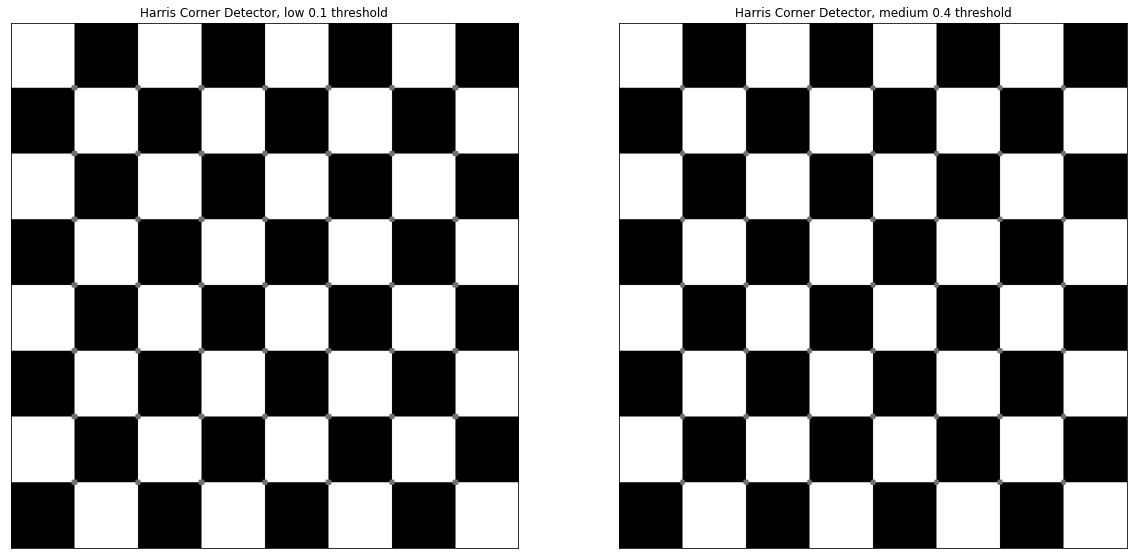

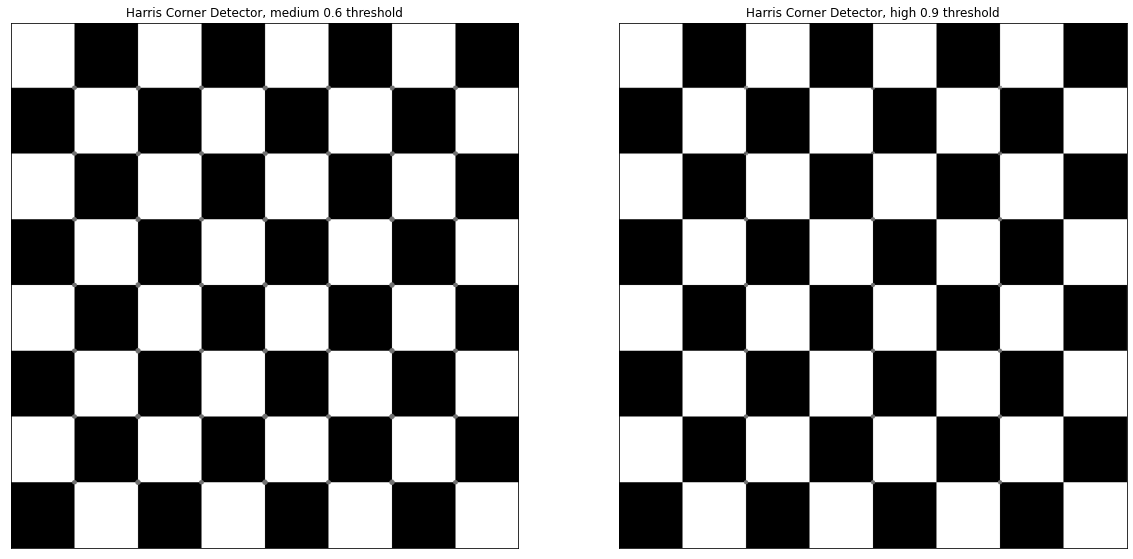

In [63]:
a1 = harris(check, 0.1)
a2 = harris(check, 0.4)
a3 = harris(check, 0.6)
a4 = harris(check, 0.9)

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(a1, cmap="gray")
plt.title("Harris Corner Detector, low 0.1 threshold"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(a2, cmap="gray")
plt.title("Harris Corner Detector, medium 0.4 threshold"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(a3, cmap="gray")
plt.title("Harris Corner Detector, medium 0.6 threshold"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(a4, cmap="gray")
plt.title("Harris Corner Detector, high 0.9 threshold"), plt.xticks([]), plt.yticks([])

plt.show

<function matplotlib.pyplot.show>

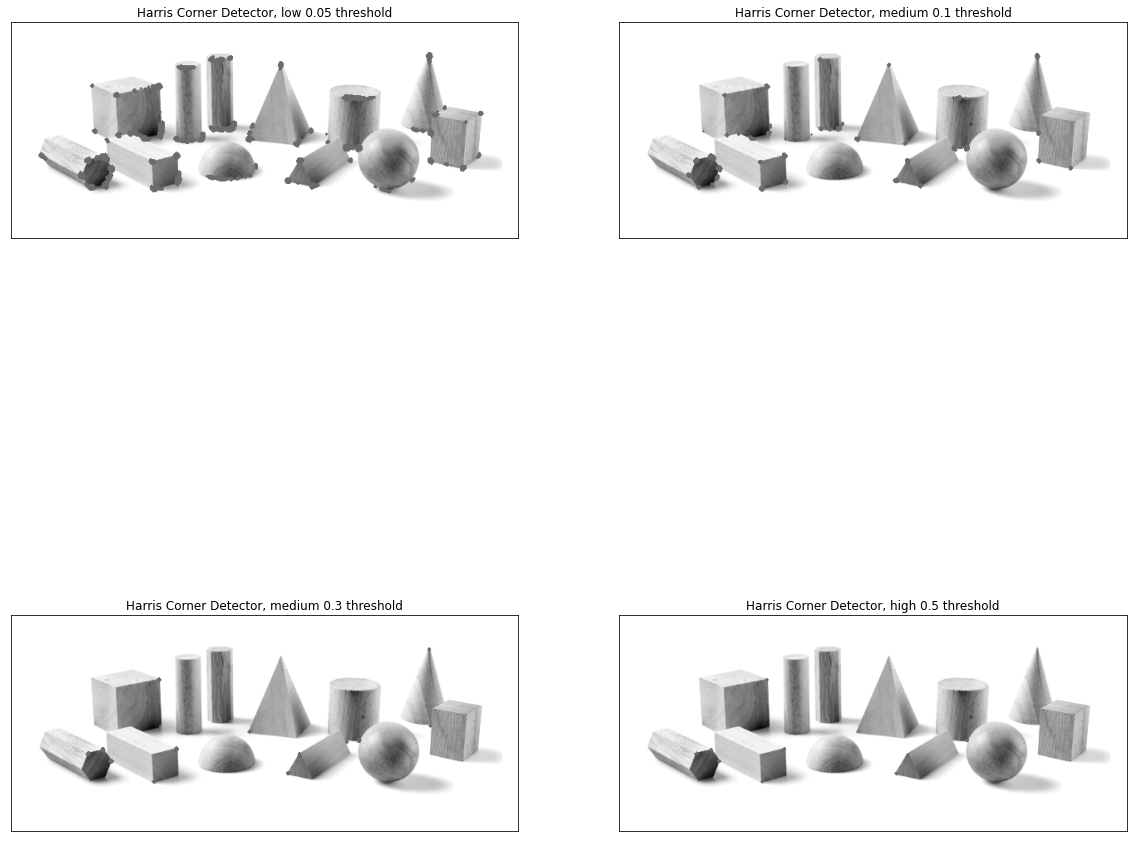

In [64]:
s1 = harris(shape, 0.05)
s2 = harris(shape, 0.1)
s3 = harris(shape, 0.3)
s4 = harris(shape, 0.5)

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(s1, cmap="gray")
plt.title("Harris Corner Detector, low 0.05 threshold"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(s2, cmap="gray")
plt.title("Harris Corner Detector, medium 0.1 threshold"), plt.xticks([]), plt.yticks([])

plt.subplot(223), plt.imshow(s3, cmap="gray")
plt.title("Harris Corner Detector, medium 0.3 threshold"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(s4, cmap="gray")
plt.title("Harris Corner Detector, high 0.5 threshold"), plt.xticks([]), plt.yticks([])

plt.show

<function matplotlib.pyplot.show>

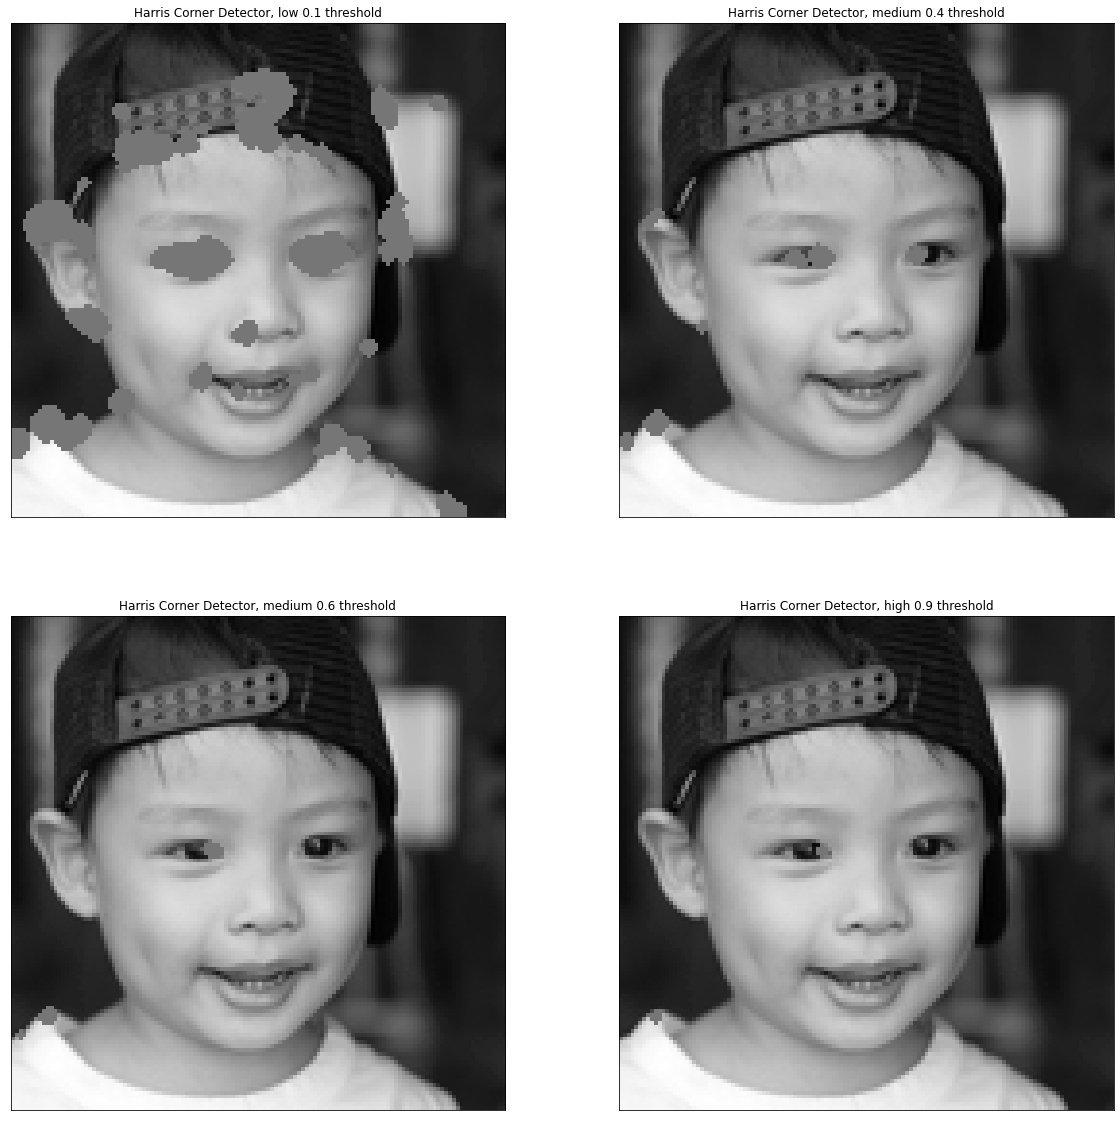

In [65]:
f1 = harris(face, 0.1)
f2 = harris(face, 0.4)
f3 = harris(face, 0.6)
f4 = harris(face, 0.9)

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(f1, cmap="gray")
plt.title("Harris Corner Detector, low 0.1 threshold"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(f2, cmap="gray")
plt.title("Harris Corner Detector, medium 0.4 threshold"), plt.xticks([]), plt.yticks([])

plt.subplot(223), plt.imshow(f3, cmap="gray")
plt.title("Harris Corner Detector, medium 0.6 threshold"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(f4, cmap="gray")
plt.title("Harris Corner Detector, high 0.9 threshold"), plt.xticks([]), plt.yticks([])

plt.show

#q4: template matching

1. iterate through og and run ssd from tmp
2. display ssd throughout img
3. display lowest ssd square

In [69]:
full = cv2.imread(a2+'find_me_image.jpg', 0)
clean = cv2.imread(a2+'template.jpg', 0)
noisy = cv2.imread(a2+'template_noisy.jpg', 0)

In [70]:
def mtch(og, tmp):
  #map fx for each px in og & tmp
  #calc ssd of intensity (greyscale picture to make things easier)
  #this only works for tmp sized slices

  stride = tmp.shape
  window = og.shape

  #a 4d arr to fit the tmp sized slices of og
  #quad[i,j,:,:] <=> og[i*stride[0], j*stride[1]]
  #used to keep mmry usage down
  #2* og byte size for quad stride 
  quad = as_strided(og, shape=(window[0] - stride[0] + 1, window[1] -stride[1] +1)+ stride, strides=(og.strides *2))
  

  #change square diff (a-b)2 to quadtratic a2-2ab+b2 to make it linearizable by einsum
  #sums everything
  ssd = np.einsum('ijkl,kl->ij', quad, tmp) 
  ssd = ssd.astype(np.int16, copy=False)      
  ssd *= -2
  ssd += np.einsum('ijkl, ijkl->ij', quad, quad)
  ssd += np.einsum('ij, ij', tmp, tmp)

  return ssd

def minpt(ssd):
  #get from ssd[i,j]
  #so get minimum sum for all tmp slices
  m = np.min(ssd)

  #and pick smallest pt
  #take slice
  i = np.where(ssd == m)
  return i

def imglist(img, coord, shape):
  #prints out 'shape' sized crops at coordinates in 'coord' from 'img'
  plt.figure(figsize=(20,20))
  for i, (x, y) in enumerate(zip(coord[0], coord[1])):
    #lst.append(img[x:(x+shape[0], y:y+shape[1])])
    x2 = x+shape[0]
    y2 = y+shape[1]
    pic = img[x:x2, y:y2]
    t = 'image {}, coordinate x={}, y={}'.format(i+1,x,y) 
    pos = math.ceil((len(coord[0]))/3) *100 + 30 + i+1
    

    plt.subplot(pos), plt.imshow(pic, cmap='gray')
    plt.title(t), plt.xticks([]), plt.yticks([])

  plt.show

from matplotlib.colors import LogNorm

def graph(img, ssd):
  plt.figure(figsize=(20,20))

  #for some reason the row/column order is reversed
  
  ymax, xmax = ssd.shape
  ystep, xstep = 1, 1
  y, x = np.mgrid[slice(0,ymax, 1), slice(0,xmax , 1)]
  #because pcolor doesnt go to the end              
  #z = ssd[:-1, :-1]
  z = ssd

  c = plt.pcolormesh(x, y, z, cmap ='BuGn', vmin = np.min(ssd), vmax = np.max(ssd))
  plt.colorbar(c)
  plt.title("colormapping of SSD values")

  plt.show

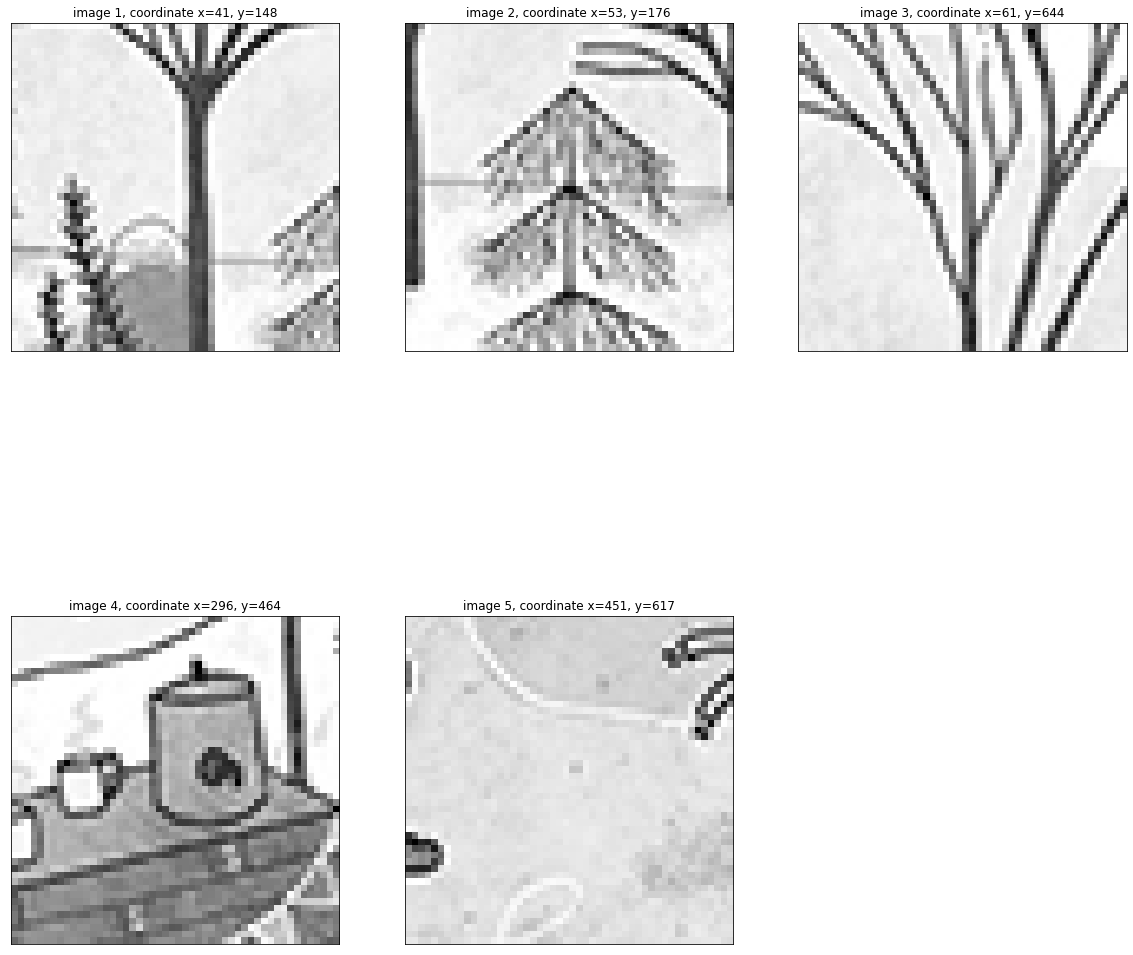

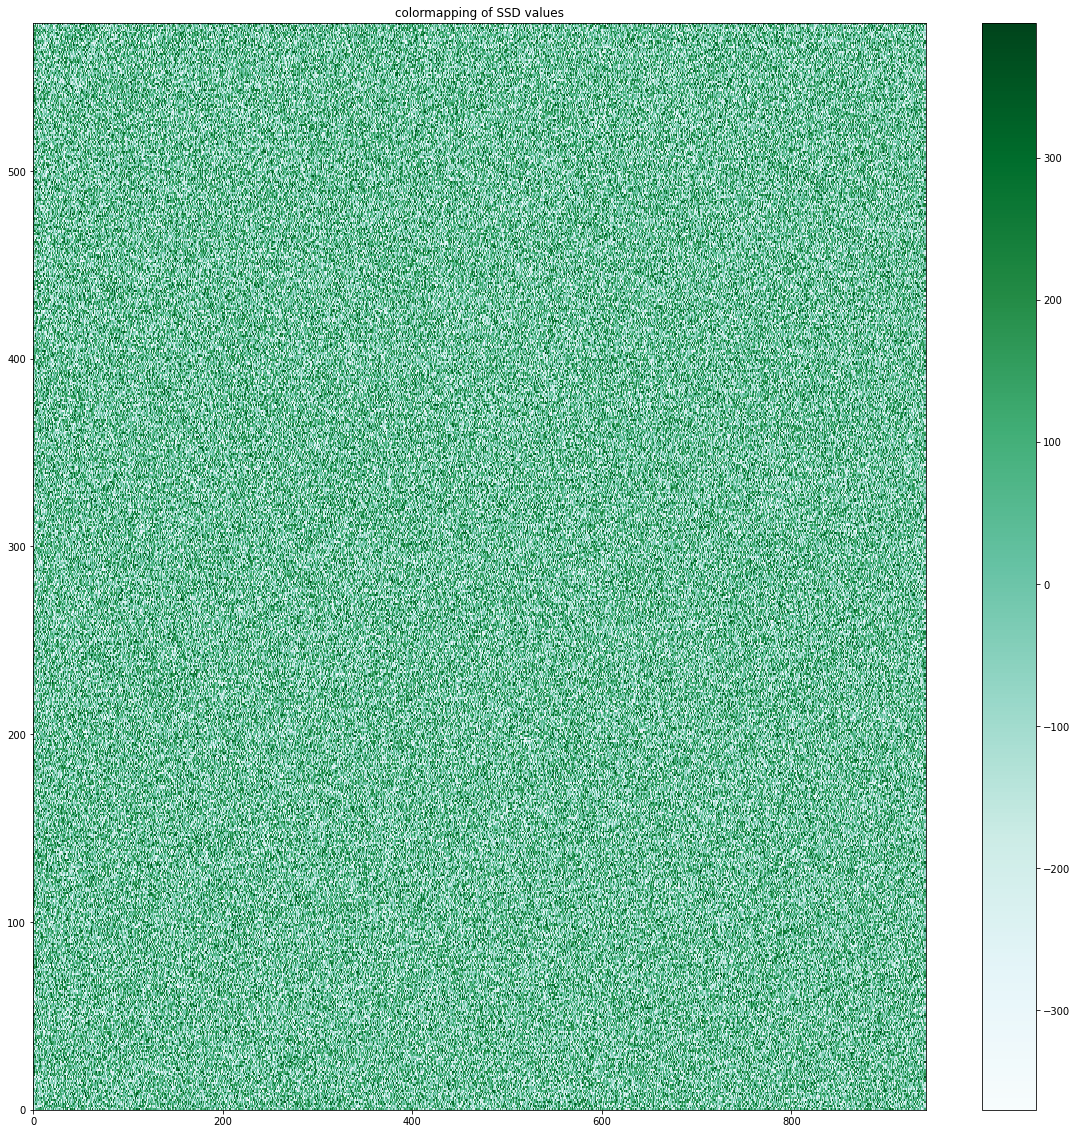

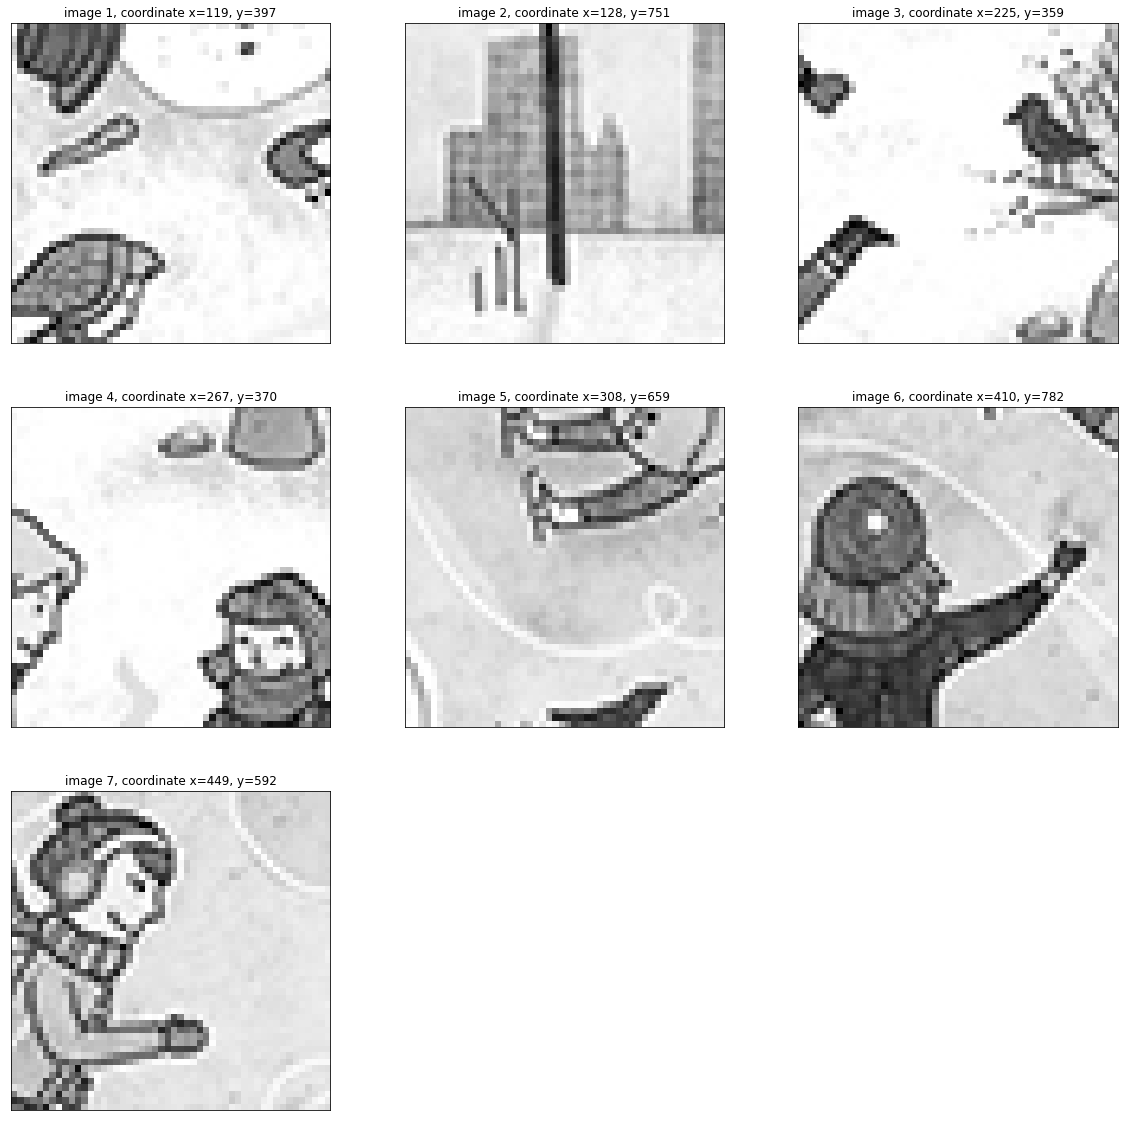

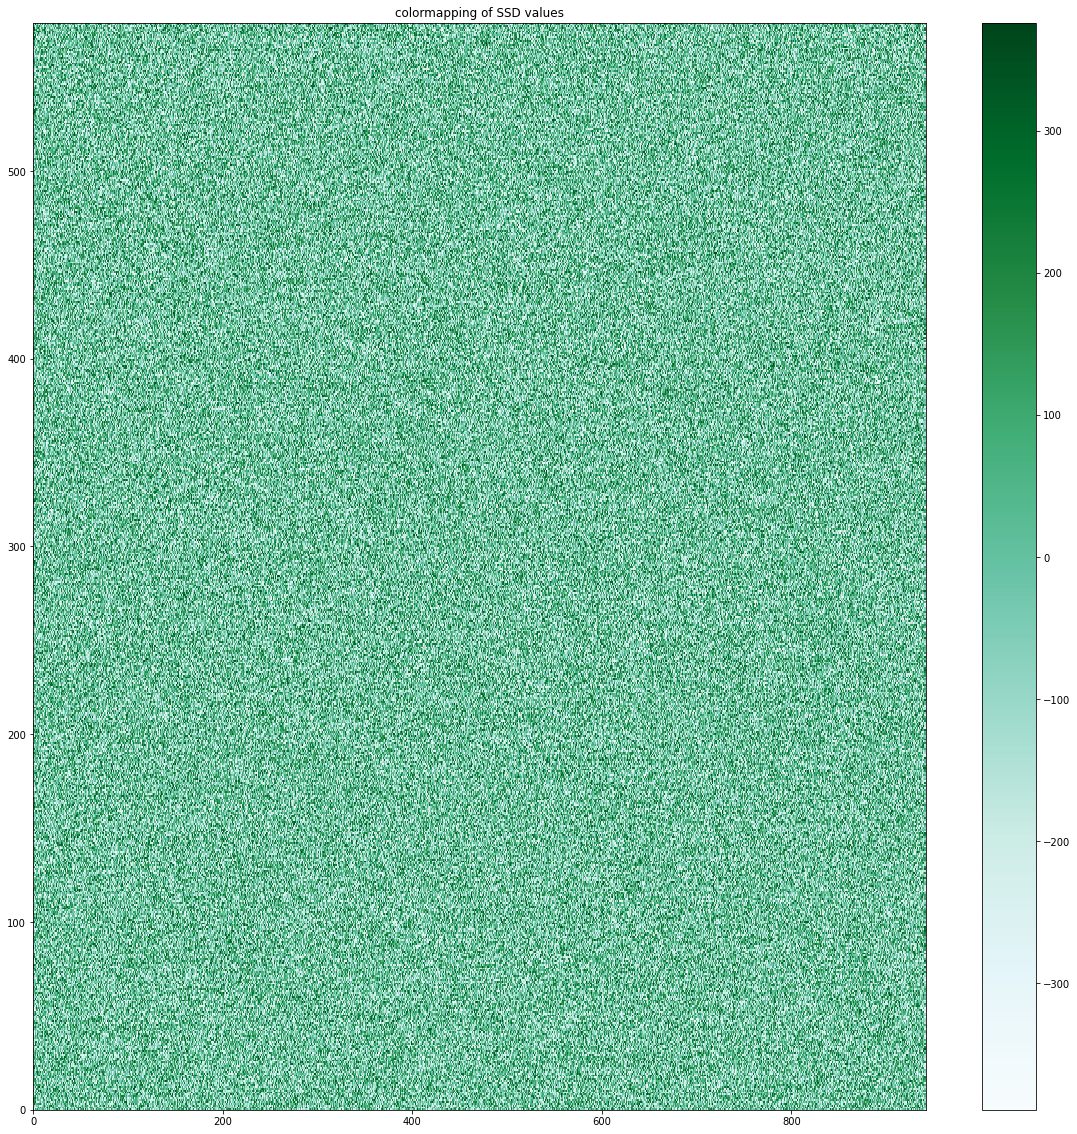

In [71]:
c = mtch(full, clean)
n = mtch(full, noisy)

imglist(full, minpt(c), clean.shape)
graph(full, c)

imglist(full, minpt(n), noisy.shape)
graph(full, n)



#commentary

this doesn't really seem to have worked here, but at least the one in the noisy one found some people. Maybe it's because the strides in the ssd comparison were too broad, or maybe the picture could have done well with a smaller template to look for.

I think that the clean one did much worse because it was too even and flat throughout; this might have fared better if it were a real photo with real color/light/shadow gradients